#### 4/24/2017

This notebook contains the Amherst-specific figures and the Add Health School figures for School \#23.

In [38]:
## implemented LINK with solver='lbfgs'
## KM Altenburger

from __future__ import division
from matplotlib.backends.backend_pdf import PdfPages
import os

os.chdir('/Users/kristen/Documents/gender_graph_code/code/0_analyze_FB100_AddHealth/')

## relevant libraries
execfile('../functions/python_libraries.py')

## processing datasets
execfile('../functions/create_adjacency_matrix.py') 
execfile('../functions/create_directed_adjacency_matrix.py')


execfile('../functions/parsing.py')
execfile('../functions/mixing.py')

## code for gender prediction 
execfile('../functions/LINK_finalized.py')
execfile('../functions/majority_vote.py')
execfile('../functions/ZGL.py')
execfile('../functions/benchmark_classifier.py')

## gender preference distribution
execfile('../functions/compute_null_distribution.py')

## Amherst College Network from FB100

In [2]:
## load Amherst only

## filename where relevant FB100 data is stored
fb100_file = '/Users/kristen/Dropbox/gender_graph_data/FB_processing_pipeline/data/0_original/'


for f in listdir(fb100_file):
    if f.endswith('.mat'):
        tag = f.replace('.mat', '')
        if (tag == 'Amherst41'):
            print tag
            input_file = path_join(fb100_file, f)
            A, metadata = parse_fb100_mat_file(input_file)

            adj_matrix_tmp = A.todense()
            gender_y_tmp = metadata[:,1] #gender
                
            gender_dict = create_dict(range(len(gender_y_tmp)), gender_y_tmp)
                
            (gender_y, adj_matrix_gender) = create_adj_membership(
                                    nx.from_numpy_matrix(adj_matrix_tmp), # graph
                                                           gender_dict,   # dictionary
                                                           0,             # val_to_drop, gender = 0 is missing
                                                           'yes',         # delete_na_cols, ie completely remove NA nodes from graph
                                                           0,             # diagonal
                                                           None,          # directed_type
                                                           'gender')      # gender
            
            gender_y = np.array(map(np.int,gender_y)) ## need np.int for machine precisions reasons

Amherst41


In [3]:
F_fb_label = 1
M_fb_label = 2

# illustrate overdispersion in Amherst

In [4]:
#F
in_F_degree = adj_matrix_gender[gender_y==F_fb_label,] * np.matrix((gender_y==F_fb_label)+0).T
total_F_degree = np.sum(adj_matrix_gender[gender_y==F_fb_label,] ,1)
h_F = np.mean(in_F_degree)/np.mean(total_F_degree)

#M
in_M_degree = adj_matrix_gender[gender_y==M_fb_label,] * np.matrix((gender_y==M_fb_label)+0).T
total_M_degree = np.sum(adj_matrix_gender[gender_y==M_fb_label,] ,1)
h_M = np.mean(in_M_degree)/np.mean(total_M_degree)


# Figure 1. Evidence of overdispersion in gender preferences on the Amherst College network.

### [confirmed 100K is enough iterations]

In [5]:
n_iter = 100000
d_iF = map(np.int,np.array(total_F_degree.T)[0])

mc_F = []
for j in range(n_iter):
    mc_F.append( np.random.binomial(n=map(np.int,np.array(total_F_degree.T)[0]), p=h_F)/d_iF)
    
mc_F_final = np.array(mc_F).flatten()


d_iM = map(np.int,np.array(total_M_degree.T)[0])
mc_M = []
for j in range(n_iter):
    mc_M.append( np.random.binomial(n=map(np.int,np.array(total_M_degree.T)[0]), p=h_M)/d_iM)
    
mc_M_final = np.array(mc_M).flatten()

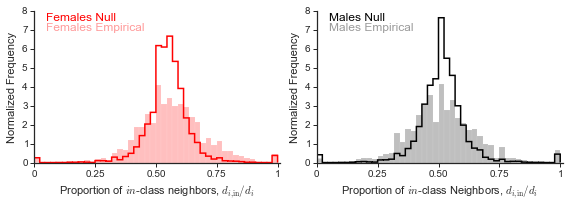

In [6]:
alpha_empirical = 0.4

%matplotlib inline
nbins = 45
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)


ax1.hist(in_F_degree/total_F_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.25)

ax1.hist(mc_F_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1.5)

ax1.set_ylabel('Normalized Frequency')
ax1.set_xlabel('Proportion of $in$-class neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,8)
ax1.set_xlim(0,1.01)

ax2.set_ylim(0,8)
ax2.set_xlim(0,1.01)
plt.setp(ax2, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)


ax2.hist(in_M_degree/total_M_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.25)
ax2.hist(mc_M_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax2.set_ylabel('Normalized Frequency')

ax1.annotate('Females Null', xy=(0.05,7.5), 
                 color='red', alpha=1, size=12)
ax1.annotate('Females Empirical', xy=(0.05,7), 
                 color='red', alpha=alpha_empirical, size=12)
ax2.annotate('Males Null', xy=(0.05,7.5), 
                 color='black', alpha=1, size=12)
ax2.annotate('Males Empirical', xy=(0.05,7), 
                 color='black', alpha=alpha_empirical, size=12)
plt.tight_layout()
pp = PdfPages('../../figures/Facebook_Amherst_overdispersion_100k.pdf')
pp.savefig()
pp.close()

In [7]:
## Amherst stats
print np.sum((gender_y==F_fb_label)+0)
print np.sum((gender_y==M_fb_label)+0)
print np.shape(adj_matrix_gender)

1015
1017
(2032, 2032)


# Figure 3A. Comparison of 1-hop versus 2-hop classifiers on Amherst College.

### LINK

In [8]:
percent_initially_unlabelled = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

In [9]:
(mean_accuracy_amherst, se_accuracy_amherst, 
 mean_micro_auc_amherst,se_micro_auc_amherst, mean_wt_auc_amherst_lbfgs,se_wt_auc_amherst)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(gender_y), ## gender labels 
                                                              np.matrix(adj_matrix_gender), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    solver='lbfgs',
                                                                                                    C=10e20),num_iter=10) 




0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


## 1-hop MV

In [10]:
(mean_accuracy_mv_amherst, se_accuracy_mv_amherst, 
 mean_micro_auc_mv_amherst,se_micro_auc_mv_amherst, 
 mean_wt_auc_mv_amherst,se_wt_auc_mv_amherst) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(gender_y), 
                                                                np.array(adj_matrix_gender), 
                                                                       num_iter=10)



0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


## 2-hop MV

In [11]:
adj_amherst2= np.matrix(adj_matrix_gender)**2
adj_amherst2[range(adj_amherst2.shape[0]),range(adj_amherst2.shape[0])]=0 ## remove self-loops

In [12]:
(mean_accuracy_mv2_amherst2, se_accuracy_mv2_amherst2, 
 mean_micro_auc_mv2_amherst2,se_micro_auc_mv2_amherst2, 
 mean_wt_auc_mv2_amherst2,se_wt_auc_mv2_amherst2) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(gender_y), 
                                                                np.array(adj_amherst2), 
                                                                num_iter=10) 



0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


## ZGL

In [13]:
(mean_accuracy_zgl_amherst, se_accuracy_zgl_amherst, 
mean_micro_auc_zgl_amherst,se_micro_auc_zgl_amherst, 
mean_wt_auc_zgl_amherst,se_wt_auc_zgl_amherst) =ZGL_finalized(np.array(adj_matrix_gender),
                                    np.array(gender_y),percent_initially_unlabelled, 
                                    num_iter=10)

0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


## Baseline Classifier

In [14]:
(mean_wt_auc_baseline_amherst,se_wt_auc_baseline_amherst) = random_classifier(np.array(adj_matrix_gender),
                                                                             np.array(gender_y),
                                                                            percent_initially_unlabelled,
                                                                             num_iter=10)

0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


/Users/kristen/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/kristen/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


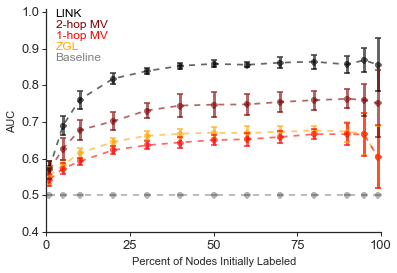

In [29]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter

fig = plt.figure()
seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')
for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.4, 0.5,0.6,0.7,0.8,0.9,1]))

        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_amherst_lbfgs, 
            yerr=se_wt_auc_amherst, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='black')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_zgl_amherst,
            yerr=se_micro_auc_zgl_amherst, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='orange')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_mv_amherst,
            yerr=se_micro_auc_mv_amherst, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='red')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_mv2_amherst2, 
            yerr=se_micro_auc_mv2_amherst2, fmt='--o', capthick=2,
                alpha=0.6, elinewidth=3, color='maroon')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_baseline_amherst, 
            yerr=se_wt_auc_baseline_amherst, fmt='--o', capthick=2,
                alpha=0.6, elinewidth=3, color='gray')
        
        grid[i].set_ylim(0.3,1.1)
        grid[i].set_xlim(0,101)
        grid[i].annotate('LINK', xy=(3, 0.99), 
                 color='black', alpha=1, size=12)
        grid[i].annotate('2-hop MV', xy=(3, 0.96), 
                 color='maroon', alpha=1, size=12)
        grid[i].annotate('1-hop MV', xy=(3, 0.93), 
                 color='red', alpha=1, size=12)
        grid[i].annotate('ZGL', xy=(3, 0.90), 
                 color='orange', alpha=1, size=12)
        grid[i].annotate('Baseline', xy=(3, 0.87), 
                 color='gray', alpha=1, size=12)
        grid[i].set_ylim(0.49,1.01)
        grid[i].set_xlim(0,100)
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=13)
        grid[i].tick_params(axis='both', which='minor', labelsize=13)
        grid[i].set_xlabel('Percent of Nodes Initially Labeled')
        grid[i].set_ylabel('AUC')

plt.setp(ax1, xticks=[0,25, 50, 75, 100], xticklabels=['0', '25', '50', '75', '100'])
grid[0].set_xticks([0,25, 50, 75, 100])
grid[0].set_yticks([ 0.4, 0.5,0.6,0.7,0.8,0.9,1])


grid[0].minorticks_on()
grid[0].tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)

pp = PdfPages('../../figures/Amherst_College_Inference.pdf')
pp.savefig()
pp.close()

# illustrate overdispersion in Add Health School #23

In [30]:
add_health_file = '/Users/kristen/Dropbox/gender_graph_data/add-health/converted_gml/'

In [24]:
for f in listdir(add_health_file):
    if f.endswith('.gml') and f=='comm23.gml': 
        tag = f.replace('.gml', '')
        print tag

        id = re.findall(r'\d+', f)
        print "Processing %s..." % f

        # directed graph
        ah_graph_directed = nx.read_gml(add_health_file+f)

        # for mutual links
        t1 = nx.adj_matrix(ah_graph_directed).todense()
        t2 = np.copy(t1.T)
        final = ((t1+t2) > 0)+0
        
        # undirected graph
        ah_graph_tmp = nx.read_gml(add_health_file+f)
        ah_graph_undirected = ah_graph_tmp.to_undirected()
            
        ## Add Health -- Undirected: Either In- or Out- Link
        (ah_gender_both, adj_gender_both) = create_adj_membership(nx.from_numpy_matrix(final),
                                                                   nx.get_node_attributes(ah_graph_directed, 'comm' + str(id[0]) +'sex'),
                                                                   0,
                                                                   'yes',
                                                                   0,
                                                                   None, # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                   'gender')
  
        ah_gender_both = np.array(map(np.int,ah_gender_both))

        (ah_gender_undirected, adj_directed_gender_undirected) = create_adj_membership(nx.from_numpy_matrix(final),
                                                                   nx.get_node_attributes(ah_graph_directed, 'comm' + str(id[0]) +'sex'),
                                                                   0,
                                                                   'yes',
                                                                   0,
                                                                   None, # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                   'gender')
        ah_gender_undirected = np.array(map(np.int,ah_gender_undirected))


        #in
        (ah_gender_in, adj_gender_in) = create_directed_adj_membership(ah_graph_directed,
                                                                nx.get_node_attributes(ah_graph_directed, 'comm' + str(id[0]) +'sex'), ## fix for non-mutual links here
                                                                   0,
                                                                   'yes',
                                                                   0,
                                                                   'in', # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                   'gender')
        ah_gender_in = np.array(map(np.int,ah_gender_in))


        #out-link
        (ah_gender_out, adj_gender_out) = create_directed_adj_membership(ah_graph_directed,
                                                                nx.get_node_attributes(ah_graph_directed, 
                                                                                       'comm' + str(id[0]) +'sex'), ## fix for non-mutual links here
                                                                   0,
                                                                   'yes',
                                                                   0,
                                                                   'out', # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                   'gender')
        ah_gender_out = np.array(map(np.int,ah_gender_out))


comm23
Processing comm23.gml...


# Null Distribution for Add Health

In [25]:
add_health_null =  compute_null_distribution(adj_directed_gender_undirected, 
                                ah_gender_undirected, 
                                100000)

In [31]:
add_health_obs = compute_observed_same_total_degree(adj_directed_gender_undirected, 
                                ah_gender_undirected)

In [32]:
print np.unique(ah_gender_undirected)

[1 2]


### undirected graph

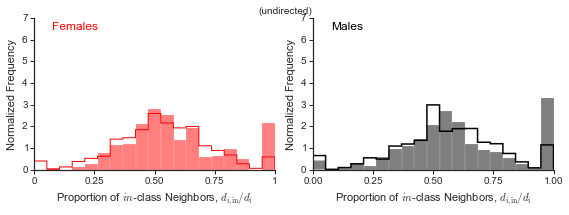

In [33]:
%matplotlib inline
nbins = 20
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
ax1.hist(add_health_obs[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.5)
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_ylabel('Normalized Frequency')
ax1.set_ylabel('Normalized Frequency')
ax2.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax1.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')


ax1.hist(add_health_null[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1)

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,7)
ax2.set_ylim(0,7)



ax2.hist(add_health_obs[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.5)

ax2.hist(add_health_null[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)



#f.text(0.5, 0.01, 'Proportion of $in$-class degrees, $d_{i,in}/d_i$', ha='center',size=10)
f.text(0.5, 0.95, '(undirected)', ha='center',size=10)
ax1.annotate('Females', xy=(0.08,6.5), 
                 color='red', alpha=1, size=12)

ax2.annotate('Males', xy=(0.08,6.5), 
                 color='black', alpha=1, size=12)


plt.tight_layout()


pp = PdfPages('../../figures/Add_Health_23_undirected_overdispersion_100k.pdf')
pp.savefig()
pp.close()

## in-directed

In [36]:
add_health_null =  compute_null_distribution(adj_gender_in, 
                                ah_gender_in, 
                                100000)
add_health_obs = compute_observed_same_total_degree(adj_gender_in, 
                                ah_gender_in)

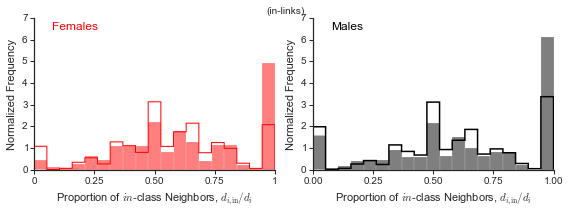

In [39]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
ax1.hist(add_health_obs[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.5)

ax1.hist(add_health_null[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1)
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_ylabel('Normalized Frequency')
ax1.set_ylabel('Normalized Frequency')
ax2.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax1.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,7)
ax2.set_ylim(0,7)



ax2.hist(add_health_obs[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.5)

ax2.hist(add_health_null[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

f.text(0.5, 0.95, '(in-links)', ha='center',size=10)
ax1.annotate('Females', xy=(0.08,6.5), 
                 color='red', alpha=1, size=12)

ax2.annotate('Males', xy=(0.08,6.5), 
                 color='black', alpha=1, size=12)


plt.tight_layout()


pp = PdfPages('../../figures/Add_Health_23_indirected_overdispersion_100k.pdf')
pp.savefig()
pp.close()

## out-directed

In [ ]:
add_health_null =  compute_null_distribution(adj_gender_out, 
                                ah_gender_out, 
                                100000)
add_health_obs = compute_observed_same_total_degree(adj_gender_out, 
                                ah_gender_out)




In [ ]:
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
ax1.hist(add_health_obs[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.5)

ax1.hist(add_health_null[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1)
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_ylabel('Normalized Frequency')
ax1.set_ylabel('Normalized Frequency')
ax2.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax1.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')


#ax1.set_ylabel('Frequency')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,7)
ax2.set_ylim(0,7)


ax2.hist(add_health_obs[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.5)

ax2.hist(add_health_null[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

f.text(0.5, 0.95, '(out-links)', ha='center',size=10)
ax1.annotate('Females', xy=(0.08,6.5), 
                 color='red', alpha=1, size=12)

ax2.annotate('Males', xy=(0.08,6.5), 
                 color='black', alpha=1, size=12)


plt.tight_layout()


pp = PdfPages('../../figures/Add_Health_23_outdirected_overdispersion_100k.pdf')
pp.savefig()
pp.close()

In [ ]:
percent_initially_unlabelled = [0.98,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

## LINK 

In [ ]:
#undirected
(mean_accuracy_ah_both, se_accuracy_ah_both, 
 mean_micro_auc_ah_both,se_micro_auc_ah_both, mean_wt_auc_ah_both,se_wt_auc_ah_both)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_both), ## gender labels 
                                                              np.array(adj_gender_both), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    C=10e20,
                                                                                                   solver='lbfgs'),
                                                                        num_iter=10,
                                                            cv_setup='None') 





In [ ]:
#undirected
(mean_accuracy_ah_undirect, se_accuracy_ah_undirect, 
 mean_micro_auc_ah_undirect,se_micro_auc_ah_undirect, mean_wt_auc_ah_undirect,se_wt_auc_ah_undirect)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_undirected), ## gender labels 
                                                              np.matrix(adj_directed_gender_undirected), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    C=10e20,
                                                                                                   solver='lbfgs'),
                                                                        num_iter=10,
                                                            cv_setup='None') 




In [ ]:
#in
(mean_accuracy_ah_in, se_accuracy_ah_in, 
 mean_micro_auc_ah_in,se_micro_auc_ah_in, mean_wt_auc_ah_in,se_wt_auc_ah_in)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_in), ## gender labels 
                                                              np.matrix(adj_gender_in), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    C=10e20,
                                                                                                   solver='lbfgs'),
                                                                        num_iter=10,
                                                            cv_setup=None) 





In [ ]:
print mean_micro_auc_ah_in

In [ ]:
#out
(mean_accuracy_ah_out, se_accuracy_ah_out, 
 mean_micro_auc_ah_out,se_micro_auc_ah_out, mean_wt_auc_ah_out,se_wt_auc_ah_out)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_out), ## gender labels 
                                                              np.matrix(adj_gender_out), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    C=10e20,
                                                                                                   solver='lbfgs'),
                                                                        num_iter=10,
                                                            cv_setup=None) 






## 1-hop MV

In [ ]:
#both
(mean_accuracy_mv_ah_both, se_accuracy_mv_ah_both, 
 mean_micro_auc_mv_ah_both,se_micro_auc_mv_ah_both, 
 mean_wt_auc_mv_ah_both,se_wt_auc_mv_ah_both) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(ah_gender_both), 
                                                                np.array(adj_gender_both), 
                                                                       num_iter=10,
                                                                  cv_setup='stratified')




In [ ]:
print mean_wt_auc_mv_ah_both

In [ ]:
#undirected
(mean_accuracy_mv_ah_un, se_accuracy_mv_ah_un, 
 mean_micro_auc_mv_ah_un,se_micro_auc_mv_ah_un, 
 mean_wt_auc_mv_ah_un,se_wt_auc_mv_ah_un) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(ah_gender_undirected), 
                                                                np.array(adj_directed_gender_undirected), 
                                                                       num_iter=10,
                                                                  cv_setup='stratified')




In [ ]:
print mean_wt_auc_mv_ah_un

In [ ]:
(mean_accuracy_mv_ah_in, se_accuracy_mv_ah_in, 
 mean_micro_auc_mv_ah_in,se_micro_auc_mv_ah_in, 
 mean_wt_auc_mv_ah_in,se_wt_auc_mv_ah_in) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(ah_gender_in), 
                                                                np.array(adj_gender_in), 
                                                                       num_iter=10,
                                                                  cv_setup='stratified')




In [ ]:
(mean_accuracy_mv_ah_out, se_accuracy_mv_ah_out, 
 mean_micro_auc_mv_ah_out,se_micro_auc_mv_ah_out, 
 mean_wt_auc_mv_ah_out,se_wt_auc_mv_ah_out) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(ah_gender_out), 
                                                                np.array(adj_gender_out), 
                                                                       num_iter=10,
                                                                  cv_setup='stratified')





## 2-hop MV

In [ ]:
adj_directed_gender_undirected2= np.matrix(adj_directed_gender_undirected)**2
adj_directed_gender_undirected2[range(adj_directed_gender_undirected2.shape[0]),range(adj_directed_gender_undirected2.shape[0])]=0



In [ ]:
adj_directed_gender_undirected2= np.matrix(adj_directed_gender_undirected)**2
adj_directed_gender_undirected2[range(adj_directed_gender_undirected2.shape[0]),range(adj_directed_gender_undirected2.shape[0])]=0


adj_directed_gender_in2= np.matrix(adj_gender_in)**2
adj_directed_gender_in2[range(adj_directed_gender_in2.shape[0]),range(adj_directed_gender_in2.shape[0])]=0

adj_directed_gender_out2= np.matrix(adj_gender_out)**2
adj_directed_gender_out2[range(adj_directed_gender_out2.shape[0]),range(adj_directed_gender_out2.shape[0])]=0



In [ ]:
(mean_accuracy_mv2_ah_undirected, se_accuracy_mv2_ah_undirected, 
 mean_micro_auc_mv2_ah_undirected,se_micro_auc_mv2_ah_undirected, 
 mean_wt_auc_mv2_ah_undirected,se_wt_auc_mv2_ah_undirected) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(ah_gender_undirected), 
                                                                np.array(adj_directed_gender_undirected2), 
                                                                num_iter=10,
                                                                  cv_setup='stratified')




In [ ]:
(mean_accuracy_mv2_ah_in, se_accuracy_mv2_ah_in, 
 mean_micro_auc_mv2_ah_in,se_micro_auc_mv2_ah_in, 
 mean_wt_auc_mv2_ah_in,se_wt_auc_mv2_ah_in) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(ah_gender_in), 
                                                                np.array(adj_directed_gender_in2), 
                                                                num_iter=10,
                                                                  cv_setup='stratified')





In [ ]:
(mean_accuracy_mv2_ah_out, se_accuracy_mv2_ah_out, 
 mean_micro_auc_mv2_ah_out,se_micro_auc_mv2_ah_out, 
 mean_wt_auc_mv2_ah_out,se_wt_auc_mv2_ah_out) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(ah_gender_out), 
                                                                np.array(adj_directed_gender_out2), 
                                                                num_iter=10,
                                                                  cv_setup='stratified')





## ZGL

In [ ]:
#undirected
(mean_accuracy_zgl_ah_undirected, se_accuracy_zgl_ah_undirected, 
mean_micro_auc_zgl_ah_undirected,se_micro_auc_zgl_ah_undirected, 
mean_wt_auc_zgl_ah_undirected,se_wt_auc_zgl_ah_undirected) =ZGL_finalized(np.array(adj_directed_gender_undirected),
                                    np.array(ah_gender_undirected),percent_initially_unlabelled, 
                                    num_iter=10,
                                                                  cv_setup='stratified')

In [ ]:
#in
(mean_accuracy_zgl_ah_in, se_accuracy_zgl_ah_in, 
mean_micro_auc_zgl_ah_in,se_micro_auc_zgl_ah_in, 
mean_wt_auc_zgl_ah_in,se_wt_auc_zgl_ah_in) =ZGL_finalized(np.array(adj_gender_in),
                                    np.array(ah_gender_in),percent_initially_unlabelled, 
                                    num_iter=10,
                                                                  cv_setup='stratified')

In [ ]:
#out
(mean_accuracy_zgl_ah_out, se_accuracy_zgl_ah_out, 
mean_micro_auc_zgl_ah_out,se_micro_auc_zgl_ah_out, 
mean_wt_auc_zgl_ah_out,se_wt_auc_zgl_ah_out) =ZGL_finalized(np.array(adj_gender_out),
                                    np.array(ah_gender_out),percent_initially_unlabelled, 
                                    num_iter=10,
                                                                  cv_setup='stratified')

## PPR

In [ ]:
(mean_accuracy_ah_undirected_ppr, se_accuracy_ah_undirected_ppr, 
 mean_micro_auc_ah_undirected_ppr,se_micro_auc_ah_undirected_ppr, 
 mean_wt_auc_ah_undirected_ppr,se_wt_auc_ah_undirected_ppr)= ppr_finalized(nx.from_numpy_matrix(adj_directed_gender_undirected),
                                                            percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_undirected), ## gender labels 
                                                              0, ## adjacency matrix
                                                             10,
                                                                cv_setup='stratified')





In [ ]:
(mean_accuracy_ah_in_ppr, se_accuracy_ah_in_ppr, 
 mean_micro_auc_ah_in_ppr,se_micro_auc_ah_in_ppr, 
 mean_wt_auc_ah_in_ppr,se_wt_auc_ah_in_ppr)= ppr_finalized(nx.from_numpy_matrix(adj_gender_in),
                                                            percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_in), ## gender labels 
                                                              0, ## adjacency matrix
                                                             10,
                                                                cv_setup='stratified')






In [ ]:
print np.unique(ah_gender_undirected)
print np.sum((ah_gender_out==1)+0)
print np.sum((ah_gender_out==2)+0)

In [ ]:
print np.unique(ah_gender_undirected)

print np.sum((ah_gender_undirected==1)+0)
print np.sum((ah_gender_undirected==2)+0)

In [ ]:
(mean_accuracy_ah_out_ppr, se_accuracy_ah_out_ppr, 
 mean_micro_auc_ah_out_ppr,se_micro_auc_ah_out_ppr, 
 mean_wt_auc_ah_out_ppr,se_wt_auc_ah_out_ppr)= ppr_finalized(nx.from_numpy_matrix(adj_gender_out),
                                                            percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_out), ## gender labels 
                                                              0, ## adjacency matrix
                                                             10,
                                                                cv_setup='stratified')







In [ ]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter
os.chdir('/Users/kristen/Dropbox/gender_graph_data/manuscript/pnas/pnas_figures/') 



fig = plt.figure()
seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')

for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.5,0.6,0.7,0.8,0.9,1]))

        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_undirect, 
            yerr=se_micro_auc_ah_undirect, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='black')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_zgl_ah_undirected,
            yerr=se_micro_auc_zgl_ah_undirected, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='orange')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_mv_ah_un,
            yerr=se_micro_auc_mv_ah_un, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='red')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_mv2_ah_undirected, 
            yerr=se_micro_auc_mv2_ah_undirected, fmt='--o', capthick=2,
                alpha=0.6, elinewidth=3, color='maroon')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_undirected_ppr, 
            yerr=se_micro_auc_ah_undirected_ppr, fmt='--o', capthick=2,
                alpha=0.6, elinewidth=3, color='purple')
        
        
        grid[i].set_ylim(0.4,1.1)
        grid[i].set_xlim(0,100)
        grid[i].annotate('LINK', xy=(3, 0.99), 
                 color='black', alpha=1, size=12)
        #grid[i].annotate('ZGL', xy=(3, 0.93), 
        #         color='hotpink', alpha=1, size=12)
        grid[i].annotate('2-hop MV', xy=(3, 0.96), 
                 color='maroon', alpha=1, size=12)
        grid[i].annotate('1-hop MV', xy=(3, 0.93), 
                 color='red', alpha=1, size=12)
        grid[i].annotate('ZGL', xy=(3, 0.90), 
                 color='orange', alpha=1, size=12)
        grid[i].annotate('PPR', xy=(3, 0.87), 
                 color='purple', alpha=1, size=12)
        grid[i].set_ylim(0.4,1.05)
        grid[i].set_xlim(0,100)
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=9)
        grid[i].tick_params(axis='both', which='minor', labelsize=9)


fig.text(0.5, 0.9, 'Gender Inference on Add Health #' +str(id[0]) + ' - undirected', ha='center', fontsize=13)        
fig.text(0.5, 0.01, '% of Nodes Initially Labeled', ha='center', fontsize=13)
fig.text(0.01, 0.5, 'AUC', va='center', rotation='vertical', fontsize=13)
plt.show()
#plt.tight_layout()
#pp = PdfPages('AddHealth_School_23_Undirected_Inference.pdf')
#pp.savefig()
#pp.close()

In [ ]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter
os.chdir('/Users/kristen/Dropbox/gender_graph_data/manuscript/pnas/pnas_figures/') 



fig = plt.figure()
seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')


for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.5,0.6,0.7,0.8,0.9,1]))

        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_undirect, 
            yerr=se_micro_auc_ah_undirect, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='black')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_in, 
            yerr=se_micro_auc_ah_in, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='red')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_out,
            yerr=se_micro_auc_ah_out, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='gray')
        
        
        grid[i].tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)


        grid[i].set_ylim(0.4,1.1)
        grid[i].set_xlim(0,100)
        grid[i].annotate('LINK: in features', xy=(3, 0.99), 
                 color='gray', alpha=1, size=12)
        #grid[i].annotate('ZGL', xy=(3, 0.93), 
        #         color='hotpink', alpha=1, size=12)
        grid[i].annotate('LINK: undirected features', xy=(3, 0.96), 
                 color='black', alpha=1, size=12)
        grid[i].annotate('LINK: out features', xy=(3, 0.93), 
                 color='red', alpha=1, size=12)

        grid[i].set_ylim(0.4,1.05)
        grid[i].set_xlim(0,100)
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=9)
        grid[i].tick_params(axis='both', which='minor', labelsize=9)


fig.text(0.5, 0.9, 'Gender Inference on Add Health #' +str(id[0]) + ' - LINK', ha='center', fontsize=13)        
fig.text(0.5, 0.01, '% of Nodes Initially Labeled', ha='center', fontsize=13)
fig.text(0.01, 0.5, 'AUC', va='center', rotation='vertical', fontsize=13)
#plt.show()
#plt.tight_layout()
pp = PdfPages('AddHealth_School_23_LINK_Inference.pdf')
pp.savefig()
pp.close()

In [ ]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter
os.chdir('/Users/kristen/Dropbox/gender_graph_data/manuscript/pnas/pnas_figures/') 



fig = plt.figure()
seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')

for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.5,0.6,0.7,0.8,0.9,1]))

        grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_ah_in, 
            yerr=se_micro_auc_ah_in, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='black')
        #grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_zgl_ah_undirected,
        #    yerr=se_micro_auc_zgl_ah_undirected, fmt='--o', capthick=2,
        #    alpha=0.6, elinewidth=3, color='orange')
        grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_mv_ah_in,
            yerr=se_micro_auc_mv_ah_in, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='red')
        grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_mv2_ah_in, 
            yerr=se_micro_auc_mv2_ah_in, fmt='--o', capthick=2,
                alpha=0.6, elinewidth=3, color='maroon')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_ah_in_ppr, 
            yerr=se_micro_auc_ah_in_ppr, fmt='--o', capthick=2,
                alpha=0.6, elinewidth=3, color='purple')
        
        
        grid[i].set_ylim(0.4,1.1)
        grid[i].set_xlim(0,100)
        grid[i].annotate('LINK', xy=(3, 0.99), 
                 color='black', alpha=1, size=12)
        #grid[i].annotate('ZGL', xy=(3, 0.93), 
        #         color='hotpink', alpha=1, size=12)
        grid[i].annotate('2-hop MV', xy=(3, 0.96), 
                 color='maroon', alpha=1, size=12)
        grid[i].annotate('1-hop MV', xy=(3, 0.93), 
                 color='red', alpha=1, size=12)
        #grid[i].annotate('ZGL', xy=(3, 0.90), 
        #         color='orange', alpha=1, size=12)
        grid[i].annotate('PPR', xy=(3, 0.87), 
                 color='purple', alpha=1, size=12)
        grid[i].set_ylim(0.4,1.05)
        grid[i].set_xlim(0,100)
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=9)
        grid[i].tick_params(axis='both', which='minor', labelsize=9)


fig.text(0.5, 0.9, 'Gender Inference on Add Health #' +str(id[0]) + ' - in-directed', ha='center', fontsize=13)        
fig.text(0.5, 0.01, '% of Nodes Initially Labeled', ha='center', fontsize=13)
fig.text(0.01, 0.5, 'AUC', va='center', rotation='vertical', fontsize=13)
#plt.show()
#plt.tight_layout()
pp = PdfPages('AddHealth_School_23_In_Inference.pdf')
pp.savefig()
pp.close()

In [ ]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter
os.chdir('/Users/kristen/Dropbox/gender_graph_data/manuscript/pnas/pnas_figures/') 



fig = plt.figure()
seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')

for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.5,0.6,0.7,0.8,0.9,1]))

        grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_ah_out, 
            yerr=se_micro_auc_ah_out, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='black')
        #grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_zgl_ah_out,
        #    yerr=se_micro_auc_zgl_ah_out, fmt='--o', capthick=2,
        #    alpha=0.6, elinewidth=3, color='orange')
        grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_mv_ah_out,
            yerr=se_micro_auc_mv_ah_out, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='red')
        grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_mv2_ah_out, 
            yerr=se_micro_auc_mv2_ah_out, fmt='--o', capthick=2,
                alpha=0.6, elinewidth=3, color='maroon')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_micro_auc_ah_out_ppr, 
            yerr=se_micro_auc_ah_out_ppr, fmt='--o', capthick=2,
                alpha=0.6, elinewidth=3, color='purple')
        
        
        grid[i].set_ylim(0.4,1.1)
        grid[i].set_xlim(0,100)
        grid[i].annotate('LINK', xy=(3, 0.99), 
                 color='black', alpha=1, size=12)
        
        grid[i].annotate('2-hop MV', xy=(3, 0.96), 
                 color='maroon', alpha=1, size=12)
        grid[i].annotate('1-hop MV', xy=(3, 0.93), 
                 color='red', alpha=1, size=12)
        #grid[i].annotate('ZGL', xy=(3, 0.90), 
        #         color='orange', alpha=1, size=12)
        grid[i].annotate('PPR', xy=(3, 0.87), 
                 color='purple', alpha=1, size=12)
        grid[i].set_ylim(0.4,1.05)
        grid[i].set_xlim(0,100)
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=9)
        grid[i].tick_params(axis='both', which='minor', labelsize=9)


fig.text(0.5, 0.9, 'Gender Inference on Add Health #' +str(id[0]) + ' - out-directed', ha='center', fontsize=13)        
fig.text(0.5, 0.01, '% of Nodes Initially Labeled', ha='center', fontsize=13)
fig.text(0.01, 0.5, 'AUC', va='center', rotation='vertical', fontsize=13)
#plt.show()
#plt.tight_layout()
pp = PdfPages('AddHealth_School_23_Out_Inference.pdf')
pp.savefig()
pp.close()

### concatenate in- and out- 

In [ ]:
#spot-check I have correct understanding of np.sum
test_matrix = np.reshape(np.matrix((1,2,10,20)),(2,2))

print test_matrix
print ''
print np.sum(test_matrix,1)
print np.sum(test_matrix,0)

In [ ]:
os.chdir('/Users/kristen/Dropbox/gender_graph_data/add-health/converted_gml/')
for f in listdir('/Users/kristen/Dropbox/gender_graph_data/add-health/converted_gml/'):
    if f.endswith('.gml') and f=='comm23.gml': #and f!='comm25.gml': #f=='comm10.gml':
        tag = f.replace('.gml', '')
        print tag

        id = re.findall(r'\d+', f)
        print "Processing %s..." % f

        # directed graph
        ah_graph_directed = nx.read_gml(f)

        # undirected graph
        #ah_graph_tmp = nx.read_gml(f)
        #ah_graph_undirected = ah_graph_tmp.to_undirected()
            
        ## Add Health -- Undirected: Either In- or Out- Link
        
        #undirected
        (ah_gender_both, adj_directed_gender_both) = create_adj_membership(ah_graph_directed,
                                                                   nx.get_node_attributes(ah_graph_directed, 'comm' + str(id[0]) +'sex'),
                                                                   0,
                                                                   'yes',
                                                                   0,
                                                                   'both', # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                   'gender')

### LINK

In [ ]:
(mean_accuracy_ah_both, se_accuracy_ah_both, 
 mean_micro_auc_ah_both,se_micro_auc_ah_both, mean_wt_auc_ah_undirect,se_wt_auc_ah_undirect)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_both), ## gender labels 
                                                              np.matrix(adj_directed_gender_both), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',C=100),
                                                                        num_iter=10,
                                                            cv_setup='stratified') 





### 1-hop MV

In [ ]:
print np.shape(adj_directed_gender_both)
print np.shape(ah_gender_both)

In [ ]:
(mean_accuracy_mv_ah_both, se_accuracy_mv_ah_both, 
 mean_micro_auc_mv_ah_both,se_micro_auc_mv_ah_both, 
 mean_wt_auc_mv_ah_both,se_wt_auc_mv_ah_both) =majority_vote_finalized(percent_initially_unlabelled,  
                                                                np.array(ah_gender_both), 
                                                                np.array(adj_directed_gender_both), 
                                                                       num_iter=10,
                                                                  cv_setup='stratified')





## PPR

In [ ]:
(mean_accuracy_ah_both_ppr, se_accuracy_ah_both_ppr, 
 mean_micro_auc_ah_both_ppr,se_micro_auc_ah_both_ppr, 
 mean_wt_auc_ah_both_ppr,se_wt_auc_ah_both_ppr)= ppr_finalized(nx.from_numpy_matrix(adj_directed_gender_both),
                                                            percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_both), ## gender labels 
                                                              0, ## adjacency matrix
                                                             10,
                                                                cv_setup='stratified')






In [ ]:
(mean_accuracy_zgl_ah_both, se_accuracy_zgl_ah_both, 
mean_micro_auc_zgl_ah_both,se_micro_auc_zgl_ah_both, 
mean_wt_auc_zgl_ah_both,se_wt_auc_zgl_ah_both) =ZGL_finalized(np.array(adj_directed_gender_both),
                                    np.array(ah_gender_both),percent_initially_unlabelled, 
                                    num_iter=10,
                                                                  cv_setup='stratified')